# Frac Production Modeling
This is a continuation of Frac Produciton Data Cleaning and Frac Production Analysis notebooks.

Here I will model with the data and optimize the models and features.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

Great, now I will write two functions to streamline training and testing the models.  The training function will fit the model and then cross validate the scores and return the scores.  The test function will cross validate and return the scores.

In [2]:
def train_model(model, X, Y, cv):
    """This function will fit the specified model and run cross validation on the training
    and set.  Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: training sets to use to fit model
    cv: number of folds in cross validation"""
    model.fit(X, Y)
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)

def test_model(model, X, Y, cv):
    """This function will run cross validation on the test set.  
    Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: test sets to use to fit model
    cv: number of folds in cross validation"""
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)


In [3]:
# Reading in ALL Colorado Features (pre-feature selection)
co_all = pd.read_csv('fracwells_co.csv', index_col=0)
co_all.head()

,WellName,WellNumber,OperatorAlias,Field,TargetFormation,TotalDepth,VerticalDepth,DrillType,UpperPerforation,LowerPerforation,...,FirstProdDate,Township,Range,TR,County,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,WEP,4-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11431.00,7551.00,H,7519.0,11431.0,...,2017-04-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001097540000,WEP,1-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11715.00,7594.00,H,8151.0,11715.0,...,2013-02-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001098010000,SHARP,24-3-11HC,WARD PETR,WATTENBERG,CODELL,10161.00,7774.00,H,NaN,NaN,...,2015-01-01,01S,67W,01S67W,Adams,1,0,1,1.0,2.533881e+06
5001097850000,STATE OF CO,1S-66-36-1609CH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12177.31,7576.73,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.274332e+06
5001097830000,STATE OF CO,1S-66-36-0108BH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12164.98,7511.68,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.045143e+06


## Modeling with ALL Colorado Features

In [4]:
# Dropping well identifiers
co_all = co_all.drop(['OperatorAlias','WellName','WellNumber','Township','Range','Field',
                      'FirstProdDate','CumBOE','CumGas','CumOil', 'TR'], axis=1)

co_all = co_all.dropna(axis=0)
co_all_d = pd.get_dummies(co_all)

co_all_features = co_all_d.drop('First6BOE', axis=1)
co_all_target = co_all_d['First6BOE']

Xa_train, Xa_test, ya_train, ya_test = train_test_split(co_all_features, co_all_target, test_size=0.25, random_state=42)

### Random Forest Regression

In [5]:
# Instantiate the model
rfra = RandomForestRegressor()
# Fit the model and generate training scores
rfra_train = train_model(rfra, Xa_train, ya_train, 5)
# Generate test scores
rfra_test = test_model(rfra, Xa_test, ya_test, 5)
print('Training Scores: {}'.format(rfra_train))
print('Test Scores: {}'.format(rfra_test))

Training Scores: 0.5417 (+/- 0.0770)
Test Scores: 0.5194 (+/- 0.1089)


Using Recursive Feature Elimination to identify the best features for this data.

In [6]:
from sklearn.feature_selection import RFE
rfr = RandomForestRegressor()
selector = RFE(rfr)
selector = selector.fit(co_all_features, co_all_target)

sel_features = pd.DataFrame(selector.support_,
                                   index = co_all_features.columns,
                                    columns=['Selected']).sort_values('Selected', ascending=False)
sel_features

,Selected
TotalDepth,True
UpperPerforation,True
LowerPerforation,True
GrossPerforatedInterval,True
HorizontalLength,True
TreatmentJobCount,True
xlinkgel,True
VerticalDepth,True
sandmass,True
TargetFormation_NIOBRARA,True


From this recursive feature elimination, I will need to eliminate the Target Formation feature and the Drill Type feature, as they are the least important in this model.

In [7]:
co_all = co_all.drop(['DrillType','County', 'TargetFormation'], axis=1)

Now, let's get a final baseline of these features for modeling using the random forest regressor.  I need to drop features and then split again.

In [8]:
co_all = pd.get_dummies(co_all)

co_sel_features = co_all.drop('First6BOE', axis=1)
co_all_target = co_all['First6BOE']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(co_sel_features, co_all_target, test_size=0.25, random_state=42)

Now, let's check how these selected features did with the random forest model.

In [9]:
# Instantiate the model
rfrs = RandomForestRegressor()
# Fit the model and generate training scores
rfrs_train = train_model(rfrs, Xs_train, ys_train, 5)
# Generate test scores
rfrs_test = test_model(rfrs, Xs_test, ys_test, 5)
print('Training Scores: {}'.format(rfrs_train))
print('Test Scores: {}'.format(rfrs_test))

Training Scores: 0.5455 (+/- 0.0668)
Test Scores: 0.4932 (+/- 0.1106)


In [10]:
feature_importances = pd.DataFrame(rfrs.feature_importances_,
                                   index = Xs_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
TotalDepth,0.256370
LowerPerforation,0.180992
GrossPerforatedInterval,0.150735
VerticalDepth,0.115076
HorizontalLength,0.094564
sandmass,0.088069
UpperPerforation,0.084065
TreatmentJobCount,0.008899
hybrid,0.007113
xlinkgel,0.006763


Alright, this is our baseline model now.  An R-squared value of 0.49 (+/- 0.11).  Interestingly enough, the four different frac method types are the least important in terms of feature importance.  I will continue with this analysis using the engineered features.

## Modeling with Selected and Engineered Features
Now I will try with the engineered features to see how they performed.

In [11]:
# Reading in Colorado Features
cofeatures = pd.read_csv('cofeatures.csv', index_col=0)
cofeatures.head()

,gel,slick,xlinkgel,hybrid,VerticalDepth,HorizontalLength,GrossPerforatedInterval,nphf_sqrt,sandmass,sqrtsandmass,sandperft,location,First6BOE,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,,,,,,
5001098010000,0,1,1,1.0,7774.00,2247.84,2901.282977,73.120155,2.533881e+06,1591.816874,249.373188,2,46241.0,1,0,0
5001097850000,0,1,1,1.0,7576.73,4499.09,5094.584805,73.515340,3.274332e+06,1809.511658,268.887993,0,7094.0,1,0,0
5001097830000,0,1,1,1.0,7511.68,4556.06,5150.088372,73.525313,3.045143e+06,1745.033863,250.320443,0,8304.0,1,0,0
5001097820000,0,1,1,1.0,7574.72,4525.40,5120.217574,73.519946,2.784211e+06,1668.595385,228.313165,1,7118.0,1,0,0
5001097810000,0,1,1,1.0,7513.70,4504.51,5099.865291,73.516289,3.056162e+06,1748.188233,252.211029,0,10385.0,1,0,0


Knowing that this data is clean, I will first identify my variables, with the first 6 month's production as the target and the remainder as features in the model.  I will then split both variables into training and test sets.

In [12]:
# Identifying all engineered features
cofeats = cofeatures.drop(['First6BOE', 'sandmass','GrossPerforatedInterval'], axis=1)

target = cofeatures.First6BOE

X_train, X_test, y_train, y_test = train_test_split(cofeats, target, test_size=0.25, random_state=42)

### Multivariate Linear Regression
I will start with multivariate linear regression to see how well the model can predict production.

In [13]:
# Instantiate the model
regr = LinearRegression()
# Fit the model and generate training scores
regr_train = train_model(regr, X_train, y_train, 5)
# Generate test scores
regr_test = test_model(regr, X_test, y_test, 5)
print('Training Scores: {}'.format(regr_train))
print('Test Scores: {}'.format(regr_test))

Training Scores: 0.3438 (+/- 0.0325)
Test Scores: 0.3236 (+/- 0.0785)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Well, that's not great.  The multivariate linear regression model only explains 32% of the variance of the model.  

Let's try some other models to see how they do.

### Random Forest Regression
The next model I will use to predict production is random forest regression. 

In [14]:
# Instantiate the model
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train, y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test, y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))

Training Scores: 0.6150 (+/- 0.0716)
Test Scores: 0.4552 (+/- 0.1757)


In [15]:
feature_importances2 = pd.DataFrame(rfr.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances2

,importance
HorizontalLength,0.403182
VerticalDepth,0.228711
nphf_sqrt,0.099679
sandperft,0.079314
sqrtsandmass,0.066043
location,0.059864
hybrid,0.037173
xlinkgel,0.020894
gel,0.003241
hzlen_bin_1-2,0.000656


That's better, except the variance in the scores increased from the linear regression models and our baseline without engineered features, which is indicative of some overfitting.  

#### Selecting Horizontal Length Feature
Since I kept in both the Horizontal length and the binned horizontal lengths, it looks like the raw values were more important than the binned version.  I will try to model with them individually to see which to keep.

In [16]:
# Instantiate the model
print('With Horizontal Length')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop(['hzlen_bin_<1','hzlen_bin_1-2', 'hzlen_bin_>2'], axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop(['hzlen_bin_<1','hzlen_bin_1-2', 'hzlen_bin_>2'], axis=1), y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

# Instantiate the model
print('With Binned Horizontal Length')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop('HorizontalLength', axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop('HorizontalLength', axis=1), y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))

With Horizontal Length
Training Scores: 0.6106 (+/- 0.0759)
Test Scores: 0.4594 (+/- 0.1696)

With Binned Horizontal Length
Training Scores: 0.6049 (+/- 0.0769)
Test Scores: 0.4633 (+/- 0.1306)


Both the R-squared and the variance decreased with the binned horizontal lenghts.  I will drop horizontal length.

#### Selecting Sand Mass Feature
Also based on the feature importances both square root of sand mass and the sand per foot seem to be of great importance to this model.  Let's see how the models differ with each individually to see which to keep.

In [17]:
# Instantiate the model
print('With Square Root Sand Mass')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop(['sandperft', 'HorizontalLength'], axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop('sandperft', axis=1), y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

# Instantiate the model
print('With Sand Mass per Foot')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop(['sqrtsandmass', 'HorizontalLength'], axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop(['sqrtsandmass', 'HorizontalLength'], axis=1), y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))

With Square Root Sand Mass
Training Scores: 0.6005 (+/- 0.0757)
Test Scores: 0.4403 (+/- 0.1762)

With Sand Mass per Foot
Training Scores: 0.6047 (+/- 0.0897)
Test Scores: 0.4664 (+/- 0.1146)


It looks like  the square root of sand mass has a lower R-squared score and a higher variance, For this reason I will keep the sand mass per foot.  This will also relieve some of the dependence between sand mass and length or depth.

In [18]:
# Dropping the least important features, Target Formation, County, 
# binned non-perforated ft, and square root sand mass
cofeats2 = cofeats.drop(['HorizontalLength', 'sqrtsandmass'], axis=1)

# Re-splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(cofeats2, target, test_size=0.25, random_state=42)

Great, now that the features have been pared down, I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [19]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200, 400, 600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6148659042599084
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 400}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [20]:
# Instantiate the model
rfr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfr_grid_train = train_model(rfr_grid, X_train, y_train, 5)
# Generate test scores
rfr_grid_test = test_model(rfr_grid, X_test, y_test, 5)
print('Training Scores: {}'.format(rfr_grid_train))
print('Test Scores: {}'.format(rfr_grid_test))

Training Scores: 0.6149 (+/- 0.0610)
Test Scores: 0.5320 (+/- 0.1286)


Even better! The test score mean increased, but there is still a sizable variance in the scores between the folds. 

Let's check out the different feature importances to see what features are influencing the model most.

,importance
VerticalDepth,0.206958
hzlen_bin_>2,0.194485
sandperft,0.173769
nphf_sqrt,0.115391
hzlen_bin_<1,0.110499
location,0.102524
hybrid,0.036981
hzlen_bin_1-2,0.027007
xlinkgel,0.024981
gel,0.005312


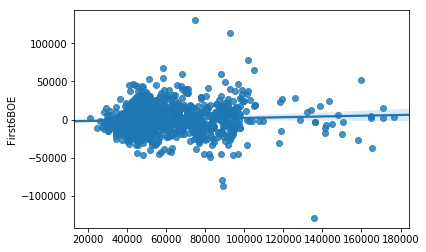

In [21]:
feature_importances3 = pd.DataFrame(rfr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances3)

# Plot Residuals vs Predicted values
y_pred = rfr_grid.predict(X_test)
residuals = y_test - y_pred
sns.regplot(x=y_pred, y=residuals)
plt.show()

There was about a 50K spread amongst the majority of the predicted values, however there were three extreme outliers with residuals of greater than 100K.

## Gradient Boosting Regressor

In [22]:
gbr = GradientBoostingRegressor(random_state=42)
# Fit the model and generate training scores
gbr_train = train_model(gbr, X_train, y_train, 5)
# Generate test scores
gbr_test = test_model(gbr, X_test, y_test, 5)
print('Training Scores: {}'.format(gbr_train))
print('Test Scores: {}'.format(gbr_test))

Training Scores: 0.5444 (+/- 0.0659)
Test Scores: 0.5105 (+/- 0.1212)


Well, this is an improvement over the random forest baseline.  Let's optimize the parameters for this model and see if the R-squared score will increase.

In [23]:
param_grid = {
               'learning_rate':[0.1,0.2],
                'n_estimators':[100,200,300],
               'min_samples_split':[12,16,24],
               'min_samples_leaf':[2,5,10],
               'max_depth':[4,6,8],
               'max_features':['sqrt'],
               'subsample':[0.8]
}

# Instantiating and fitting grid search
grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6364373438550537
{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 24, 'n_estimators': 200, 'subsample': 0.8}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [24]:
# Instantiate the model
gbr_grid = GradientBoostingRegressor(**best_params, random_state=42)
# Fit the model and generate training scores
gbr_grid_train = train_model(gbr_grid, X_train, y_train, 5)
# Generate test scores
gbr_grid_test = test_model(gbr_grid, X_test, y_test, 5)
print('Training Scores: {}'.format(gbr_grid_train))
print('Test Scores: {}'.format(gbr_grid_test))

Training Scores: 0.6365 (+/- 0.0634)
Test Scores: 0.5040 (+/- 0.0959)


Even better! The test score mean increased, but there is still a sizable variance in the scores between the folds. 

Let's check out the different feature importances to see what features are influencing the model most.

,importance
sandperft,0.286995
VerticalDepth,0.282592
nphf_sqrt,0.266550
location,0.074313
hzlen_bin_>2,0.030153
hzlen_bin_<1,0.021964
hybrid,0.012195
hzlen_bin_1-2,0.010810
xlinkgel,0.010599
gel,0.002937


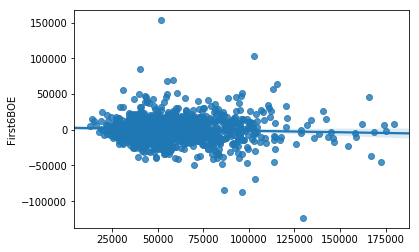

In [25]:
feature_importances4 = pd.DataFrame(gbr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances4)

# Plot Residuals vs Predicted values
y_pred = gbr_grid.predict(X_test)
residuals = y_test - y_pred
sns.regplot(x=y_pred, y=residuals)
plt.show()

## Random Forest Quantile Regressor
Because my features and especially my target are non-normally distributed even after tranformations, I will try a random forest quantile regressor.  In a quantile decision tree, the trees predict the percentile and quantile for the data point.  This means that each sample is searched for a leaf that it falls into and a weight is given to that data point based on the fraction of samples in that same leaf, and the weights are summed and averaged.  The output is then the percentile of the data set.

In [26]:
from skgarden import RandomForestQuantileRegressor
rfqr = RandomForestQuantileRegressor(random_state=42)
rfqr_train = train_model(rfqr, X_train, y_train, 5)
rfqr_test = test_model(rfqr, X_test, y_test, 5)
print('Training Scores: {}'.format(rfqr_train))
print('Test Scores: {}'.format(rfqr_test))

Training Scores: 0.6047 (+/- 0.0897)
Test Scores: 0.4664 (+/- 0.1146)




I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [27]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200, 400, 600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfqr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6148659042599084
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 400}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [28]:
# Instantiate the model
rfqr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfqr_grid_train = train_model(rfqr_grid, X_train, y_train, 5)
# Generate test scores
rfqr_grid_test = test_model(rfqr_grid, X_test, y_test, 5)
print('Training Scores: {}'.format(rfqr_grid_train))
print('Test Scores: {}'.format(rfqr_grid_test))

Training Scores: 0.6152 (+/- 0.0603)
Test Scores: 0.5362 (+/- 0.1259)


This looks better! I'm still surprised at how low the overall R-squared score is, but there is a large amount of variablility in this data, not only in the production, but also each of the individual well characteristics, including frac method. 

,importance
VerticalDepth,0.206821
hzlen_bin_>2,0.177168
sandperft,0.167558
hzlen_bin_<1,0.126156
nphf_sqrt,0.116302
location,0.103713
hybrid,0.037113
hzlen_bin_1-2,0.031709
xlinkgel,0.026212
gel,0.005095


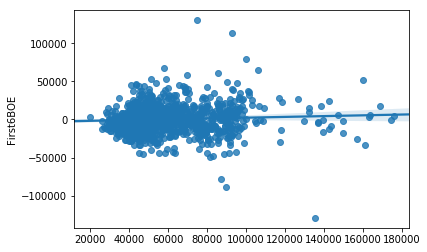

In [29]:
feature_importances5 = pd.DataFrame(rfqr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances5)

# Plot Residuals vs Predicted values
y_pred = rfqr_grid.predict(X_test)
residuals = y_test - y_pred
sns.regplot(x=y_pred, y=residuals)
plt.show()


For now, I will finish analyzing the Colorado data by inspecting the partial dependency plots because the overall goal is to better understand how each feature contributes to the production of the well.  

## Partial Dependency Plots
Partial dependency plots enable a view inside of the black boxes that are random forests.  They show how the outcome depends on each individual feature in the model.  This way we can get "coefficients" for each feature and see anomalies in the patterns.  I will also use the horizontal length feature to determine the variablity in that feature.

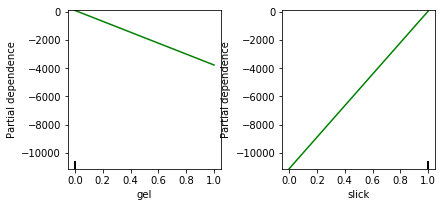

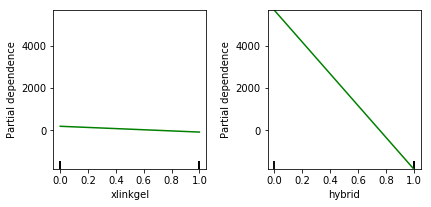

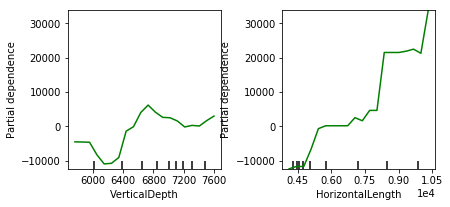

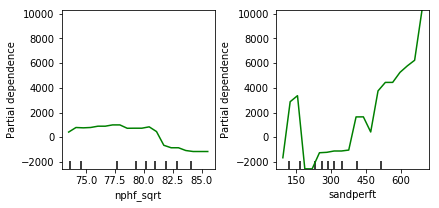

In [30]:
cofeats = cofeatures.drop(['First6BOE', 'sandmass','GrossPerforatedInterval', 
                           'sqrtsandmass','hzlen_bin_<1','hzlen_bin_1-2', 
                           'hzlen_bin_>2'], axis=1)

target = cofeatures.First6BOE


gbr = GradientBoostingRegressor()
gbr.fit(cofeats, target)

feats = [[0,1],
         [2,3],
        [4,5], 
         [6,7]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr,
                                features=feat_set, # Column numbers to plot
                                X=cofeats, # Raw predictors data
                                n_cols=2,
                                feature_names=cofeats.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

## Frac Well Summary
For this project, I wanted to build models that would help well operators in Colorado both understand the data-based best practices for frac methods, and be able to predict the production of the well within the first six months. The information I used and engineered to perform this analysis were the frac method, namely slickwater, linear gel, crosslinked gel, or a hybrid approach; the drilling conditions, including the horizontal length and the vertical depth of a well; and finally the frac conditions, including the amount of sand used per foot drilled, and the length of un-perforated casing. Through partial dependency plots and feature importances, here are the most important features and how they impact production:
- Horizontal Length
    - Lengths of less than 1 mile had lowest odds of production, between 1 and 2 miles there is very little change in the odds of production, and at greater than two miles of horizontal length there are the greatest odds of higher production levels.
- Vertical Depth
    - The odds of higher production based on vertical depth increases between 6250 ft and peaks at 6600 ft.  After 6600 ft, the odds of higher production decreases.
- Sand per Foot
    - Based on pounds of sand per foot of casing, there is a spike in the odds of higher production around 150 pounds per foot, which then drops between  200 and 350 pounds of sand per foot, and then increases steadily as the amount of sand increases.
    
This means that while there is a cost to increasing the each of these attributes of the well, well operators would do well to aim for around 2 miles of horizontal, 6600 ft vertical, and around 600+ pounds of sand per foot of casing.  As for the frac methods, the following are the analysis of their impact on frac production according to the overall model:
- Slickwater
    - Using a slickwater approach had great impact on the odds of higher production as compared to not using slickwater. 
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - Using cross-linked gel has very little impact on the odds of production.
- Hybrid Approach
    - The odds of production are higher if a hybrid approach is not used.
    
This is not very informative, most likely because the overall model looked at all attributes of the well, not just the frac method approach.  I will now model only the frac methods to interpret the odds of increased production.

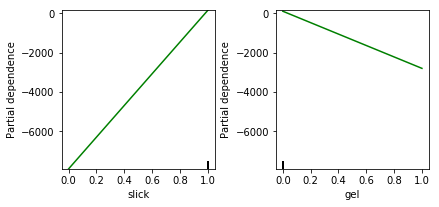

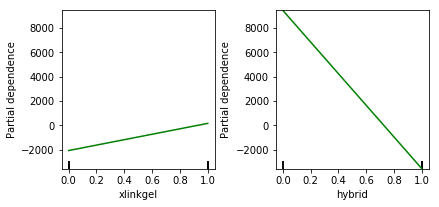

In [31]:
method = cofeats[['slick', 'gel', 'xlinkgel', 'hybrid']]

gbr_m = GradientBoostingRegressor(random_state=42)
gbr_m.fit(method, target)

feats = [[0,1],
         [2,3]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr_m,
                                features=feat_set, # Column numbers to plot
                                X=method, # Raw predictors data
                                n_cols=2,
                                feature_names=method.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

According to the model only looking at how frac method affects production, the following are the analysis of their impact on frac production:
- Slickwater
    - Using a slickwater approach increases the odds of higher production.
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - Using a cross-linked gel causes a moderate increase in the odds of higher production.
- Hybrid Approach
    - The odds of production are higher if a hybrid approach is not used.
    
__Overall, a well operator would be best off if they used a slickwater approach or a cross-linked gel approach to fracing, but linear gels and hybrid approaches are not recommended.__  

In [32]:
# Printing models all together
print('R-squared Scores on the Test Set:\n')
print('Random Forest Regression \t\t{}'.format(rfr_grid_test))
print('\nRandom Forest Quantile Regression \t{}'.format(rfqr_grid_test))
print('\nGradient Boosting Regression \t\t{}'.format(gbr_grid_test))

R-squared Scores on the Test Set:

Random Forest Regression 		0.5320 (+/- 0.1286)

Random Forest Quantile Regression 	0.5362 (+/- 0.1259)

Gradient Boosting Regression 		0.5040 (+/- 0.0959)


Overall, all three models were fairly close in their ability to predicte the first 6 months of production, however the best model was the Random Forest Quantile Regression model, with an R-squared value of 0.5328 +/- 0.13. The Random forest regression had an R-squared value of 0.5352 +/- 0.12, and the gradient boosting regression had the lowest R-squared value of 0.5040 +/- 0.10. The Gradient boosting regression, along with partial dependency plots, were able to  paint a picture of the importances of the different well and frac characteristics to determine what contributes to higher oil and gas production.

## Proof of Concept
Now I will take a couple wells and demonstrate that with different frac methods, the model will predict different levels of production. I will take a well that, according to the data, didn't use any of the frac methods I studied (it could have used another method or just wasn't identified in my cleaning of the frac focus data).  I will use the drilling characteristics of the well to determine which frac method could have improved the production of this well.

In [33]:
well = cofeats2[cofeats2.index==5001098410000]
well

,gel,slick,xlinkgel,hybrid,VerticalDepth,nphf_sqrt,sandperft,location,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5001098410000,0,0,0,0.0,8045.0,73.509025,247.216535,2,1,0,0


Now, using this well, I will individually set each method to true (1), including a hybrid of slickwater and linear gel, and a hybrid of slickwater and crosslinked gel.

In [34]:
# Creating data frame for the proof of concept wells and a data frame to store the predicted production
poc = pd.DataFrame()
preds = pd.DataFrame(columns=['Method','Predicted_Production'])

# Identifying all methods
methods = ['gel','slick','xlinkgel']

for method in methods:
    well_ex = cofeats2[cofeats2.index==5005072500000]
    # Setting each method to 1
    well_ex['slick'] = 0
    well_ex[method] = 1
    # Appending the well to the data frame
    poc = poc.append(well_ex)
    # Predicting the production of that method
    pred = rfqr_grid.predict(well_ex)
    # Appending the predicted production and method
    preds = preds.append({'Method':method, 'Predicted_Production':int(pred)}, ignore_index=True)
    
# Identifying the two hybrid types
hybrids = ['gel', 'xlinkgel']

for hybrid in hybrids:
    well_ex = cofeats2[cofeats2.index==5005072500000]
    # Setting hybrid and slick to 1 (all hybrids are a hybrid of slickwater and something else)
    well_ex['hybrid'] = 1
    well_ex['slick'] = 1
    # Setting the second hybrid ingredient to 1 and appending to the data frame
    well_ex[hybrid] = 1
    poc = poc.append(well_ex)
    # Predicting the production of that method
    pred = rfqr_grid.predict(well_ex)
    # Appending the predicted production and method
    preds = preds.append({'Method':'slick_'+ hybrid + '_hybrid', 'Predicted_Production':int(pred)}, ignore_index=True)
    
# Predicting based on existing no-method fracing
well_pred = rfqr_grid.predict(well)
preds = preds.append({'Method':'No Method', 'Predicted_Production': int(well_pred)}, ignore_index=True)
    
display(poc)
# Sorting predicted values
preds.sort_values('Predicted_Production', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,gel,slick,xlinkgel,hybrid,VerticalDepth,nphf_sqrt,sandperft,location,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5005072500000,1,0,0,0.0,7785.0,82.217212,53.159205,0,0,1,0
5005072500000,0,1,0,0.0,7785.0,82.217212,53.159205,0,0,1,0
5005072500000,0,0,1,0.0,7785.0,82.217212,53.159205,0,0,1,0
5005072500000,1,1,0,1.0,7785.0,82.217212,53.159205,0,0,1,0
5005072500000,0,1,1,1.0,7785.0,82.217212,53.159205,0,0,1,0


,Method,Predicted_Production
1,slick,74251
4,slick_xlinkgel_hybrid,68444
2,xlinkgel,68040
0,gel,66283
3,slick_gel_hybrid,65424
5,No Method,36569


Great, the poc data frame looks like it appropriately labeled each iteration of the well to have a different method, and it appears that the slickwater method has the highest predicted production out of all of the methods.  Let's graph these values to better visualize the differences.

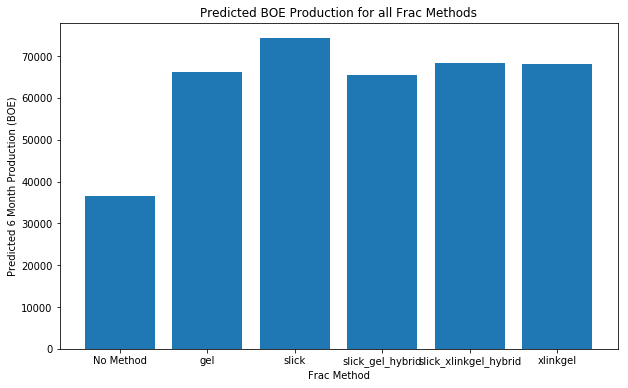

In [35]:
plt.figure(figsize=(10,6))
plt.bar(preds['Method'], height=preds['Predicted_Production'])
plt.xlabel('Frac Method')
plt.ylabel('Predicted 6 Month Production (BOE)')
plt.title('Predicted BOE Production for all Frac Methods')
plt.show()

Yes, the slickwater method of fracing is predicted to have the largest production, followed by the slickwater-linear gel hybrid.  The slickwater-cross-linked gel hybrid is predicted to have slightly less production, followed again by the cross-linked gel and linear gel methods.  My suggestion to well operators is to use the slickwater method, as in this example well, production could be 9,800 BOE greater with this method than with others.  Finally, since this well was not identified as having any of these methods of fracing, it is important to note that the no-method option performed the worst.  Unfortunately the actual production after 6 months for this well was only 23,404 BOE, so all of these predictions are about 200% of the actual. 

In [36]:
# Printing actual production of this well
target.loc[5005072500000]

67427.0

#### Proof of Concept - Well 2

In [37]:
poc = pd.DataFrame()
preds = pd.DataFrame(columns=['Method','Predicted_Production'])

# Identifying all methods
methods = ['gel','slick','xlinkgel']

for method in methods:
    well_ex = cofeats2[cofeats2.index==5123447110000]
    well_ex['slick'] = 0
    # Setting each method to 1
    well_ex[method] = 1
    # Appending the well to the data frame
    poc = poc.append(well_ex)
    # Predicting the production of that method
    pred = rfqr_grid.predict(well_ex)
    # Appending the predicted production and method
    preds = preds.append({'Method':method, 'Predicted_Production':int(pred)}, ignore_index=True)
    
# Identifying the two hybrid types
hybrids = ['gel', 'xlinkgel']

for hybrid in hybrids:
    well_ex = cofeats2[cofeats2.index==5123447110000]
    # Setting hybrid and slick to 1 (all hybrids are a hybrid of slickwater and something else)
    well_ex['hybrid'] = 1
    well_ex['slick'] = 1
    # Setting the second hybrid ingredient to 1 and appending to the data frame
    well_ex[hybrid] = 1
    poc = poc.append(well_ex)
    # Predicting the production of that method
    pred = rfqr_grid.predict(well_ex)
    # Appending the predicted production and method
    preds = preds.append({'Method':'slick_'+ hybrid + '_hybrid', 'Predicted_Production':int(pred)}, ignore_index=True)
    
# Predicting based on existing no-method fracing
well_pred = rfqr_grid.predict(well)
preds = preds.append({'Method':'No Method', 'Predicted_Production': int(well_pred)}, ignore_index=True)
    
display(poc)
# Sorting predicted values
preds.sort_values('Predicted_Production', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a co

,gel,slick,xlinkgel,hybrid,VerticalDepth,nphf_sqrt,sandperft,location,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5123447110000,1,0,0,0.0,7443.0,74.562688,685.835782,0,0,0,1
5123447110000,0,1,0,0.0,7443.0,74.562688,685.835782,0,0,0,1
5123447110000,0,0,1,0.0,7443.0,74.562688,685.835782,0,0,0,1
5123447110000,1,1,0,1.0,7443.0,74.562688,685.835782,0,0,0,1
5123447110000,0,1,1,1.0,7443.0,74.562688,685.835782,0,0,0,1


,Method,Predicted_Production
1,slick,100117
2,xlinkgel,86407
0,gel,84709
4,slick_xlinkgel_hybrid,78039
3,slick_gel_hybrid,71196
5,No Method,36569


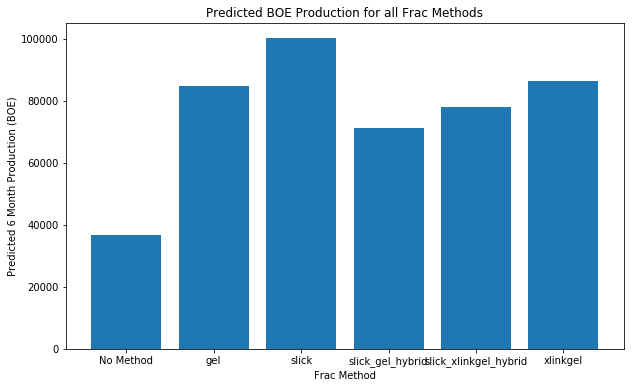

In [38]:
plt.figure(figsize=(10,6))
plt.bar(preds['Method'], height=preds['Predicted_Production'])
plt.xlabel('Frac Method')
plt.ylabel('Predicted 6 Month Production (BOE)')
plt.title('Predicted BOE Production for all Frac Methods')
plt.show()